In [6]:
import requests
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from time import sleep
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from collections import Counter

In [11]:
api_v = '5.81'
TOKEN = "vk1.a.wn0hEwFF9dBITKM40rBaYrS3_rpvDzfA5IBlRi5bRDYEU0XRp3X1wPiKTCyrfB3osWy6XqP2v7WzsncjEal7Q6wHDb6JH05iZg72lfdqf0Usc_iPnQSOHPGdz21QmioRLELE9_QirdYc1J-7DgLWzi3ivP5YUSYNR_e-jEVJObp71qJUY3rXrB2zaj062Hzp"
my_id = 416204521

In [12]:
def request_url(method_name, parameters, access_token=False):
    return f'https://api.vk.com/method/{method_name}?{parameters}&v={api_v}&access_token={TOKEN}'


# use https://vk.com/dev/friends.get
def get_friends(id_user):
    r = requests.get(request_url('friends.get', f'user_id={id_user}&fields=uid&count=10000')).json()['response']
    r["items"] = list(filter((lambda x: 'deactivated' not in x.keys()), r['items']))
    return {item['id']: item for item in r['items']}, r['count']


# use https://vk.com/dev/users.get
def get_base_info(ids):
    return requests.get(request_url(
        'users.get', 
        f"user_ids={','.join(map(str, ids))}&fields=photo,sex,city,universities")
    ).json()['response']

In [13]:
counter_global = 2

In [14]:
my_friends, my_friends_amount = get_friends(my_id) # get my frieds list

In [15]:
print(list(my_friends.keys())[:5])

[809203, 3656763, 7153638, 9348223, 19651650]


In [16]:
total_friends = {}

In [17]:
# get friends of my friends
for key in tqdm(list(my_friends.keys())):
    friends_dict, amount = get_friends(key)
    total_friends[key] = friends_dict
    # sleep(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:37<00:00,  2.21it/s]


In [18]:
print("Total length relations:", sum(map(lambda x: len(list(total_friends[x].keys())), total_friends.keys())))

Total length relations: 34585


In [19]:
my_edges = []
for friend_id in total_friends.keys():
    my_edges.append((my_id, friend_id))
    for friend_friend_id in total_friends[friend_id].keys():
        my_edges.append((friend_id, friend_friend_id))

print("Edges before filter amount:", len(my_edges))

Edges before filter amount: 34669


In [20]:
full_graph = nx.Graph()
full_graph.add_edges_from(my_edges)

In [21]:
print("Nodes amount:", len(full_graph.nodes()))
print("Relations amounts:", len(full_graph.edges()))

Nodes amount: 21389
Relations amounts: 33900


In [22]:
G = nx.Graph()

In [23]:
for friend_id in my_friends.keys():
    G.add_node(friend_id, **{key: my_friends[friend_id][key] for key in ['first_name', 'last_name']})

In [24]:
for node in G.nodes():
    for friend_id in total_friends[node]:
        # if friend of friend is my friend we add the edge
        if friend_id in my_friends.keys():
            G.add_edge(node, friend_id)

In [25]:
# delete nodes with zero degree
to_remove = []
for node in G.nodes():
    if G.degree[node] == 0:
        to_remove.append(node)
for node in to_remove:
    G.remove_node(node)

In [26]:
print("Friends amount:", len(G.nodes()))
print("Relations amounts:", len(G.edges()))

Friends amount: 78
Relations amounts: 695


In [27]:
# function for draw labels
def labels_list_parameters(graph, layout, special_vertexes=[], border_degree=5):
    list_params = []
    dict_params = {}
    max_vertex_degree = max(val for (node, val) in G.degree())
    for vertex in graph:
        vertex_degree = G.degree[vertex]
        if vertex_degree < border_degree and vertex not in special_vertexes:
            continue
        if vertex_degree not in dict_params.keys():
            dict_params[vertex_degree] = {
                'G': graph,
                'pos' : {},
                'font_size': max(10, 4 * np.log(vertex_degree ** 1.5 + 0.7)),
                'labels': {},
            }
        dict_params[vertex_degree]['labels'][vertex] = f"{graph.nodes[vertex]['first_name']} {graph.nodes[vertex]['last_name']}"
        dict_params[vertex_degree]['pos'][vertex] = np.array(
            [layout[vertex][0], layout[vertex][1] - 0.0035 * np.sqrt(vertex_degree * 0.8)])
    list_params = sorted([value for value in dict_params.values()], key=lambda x: x['font_size'])
    return list_params

In [28]:
# function for get nodes colors
def get_nodes_colors(graph):
    list_colors = []
    max_vertex_degree = max(val for (node, val) in G.degree())
    for vertex in graph:
        vertex_degree = graph.degree[vertex]
        list_colors.append(np.array([70, 70, vertex_degree / max_vertex_degree * 200, 
                                     50 + vertex_degree / max_vertex_degree * 200]) / 255)
    return list_colors

In [29]:
# experiments with improving layout
def improve_layout(layout):
#     for p in layout.values():
#         p[0] = np.exp(1 - np.abs(p[0])) ** 1.1 * p[0]
#         p[1] = np.exp(1 - np.abs(p[1])) ** 1.1 * p[1] 
    return layout

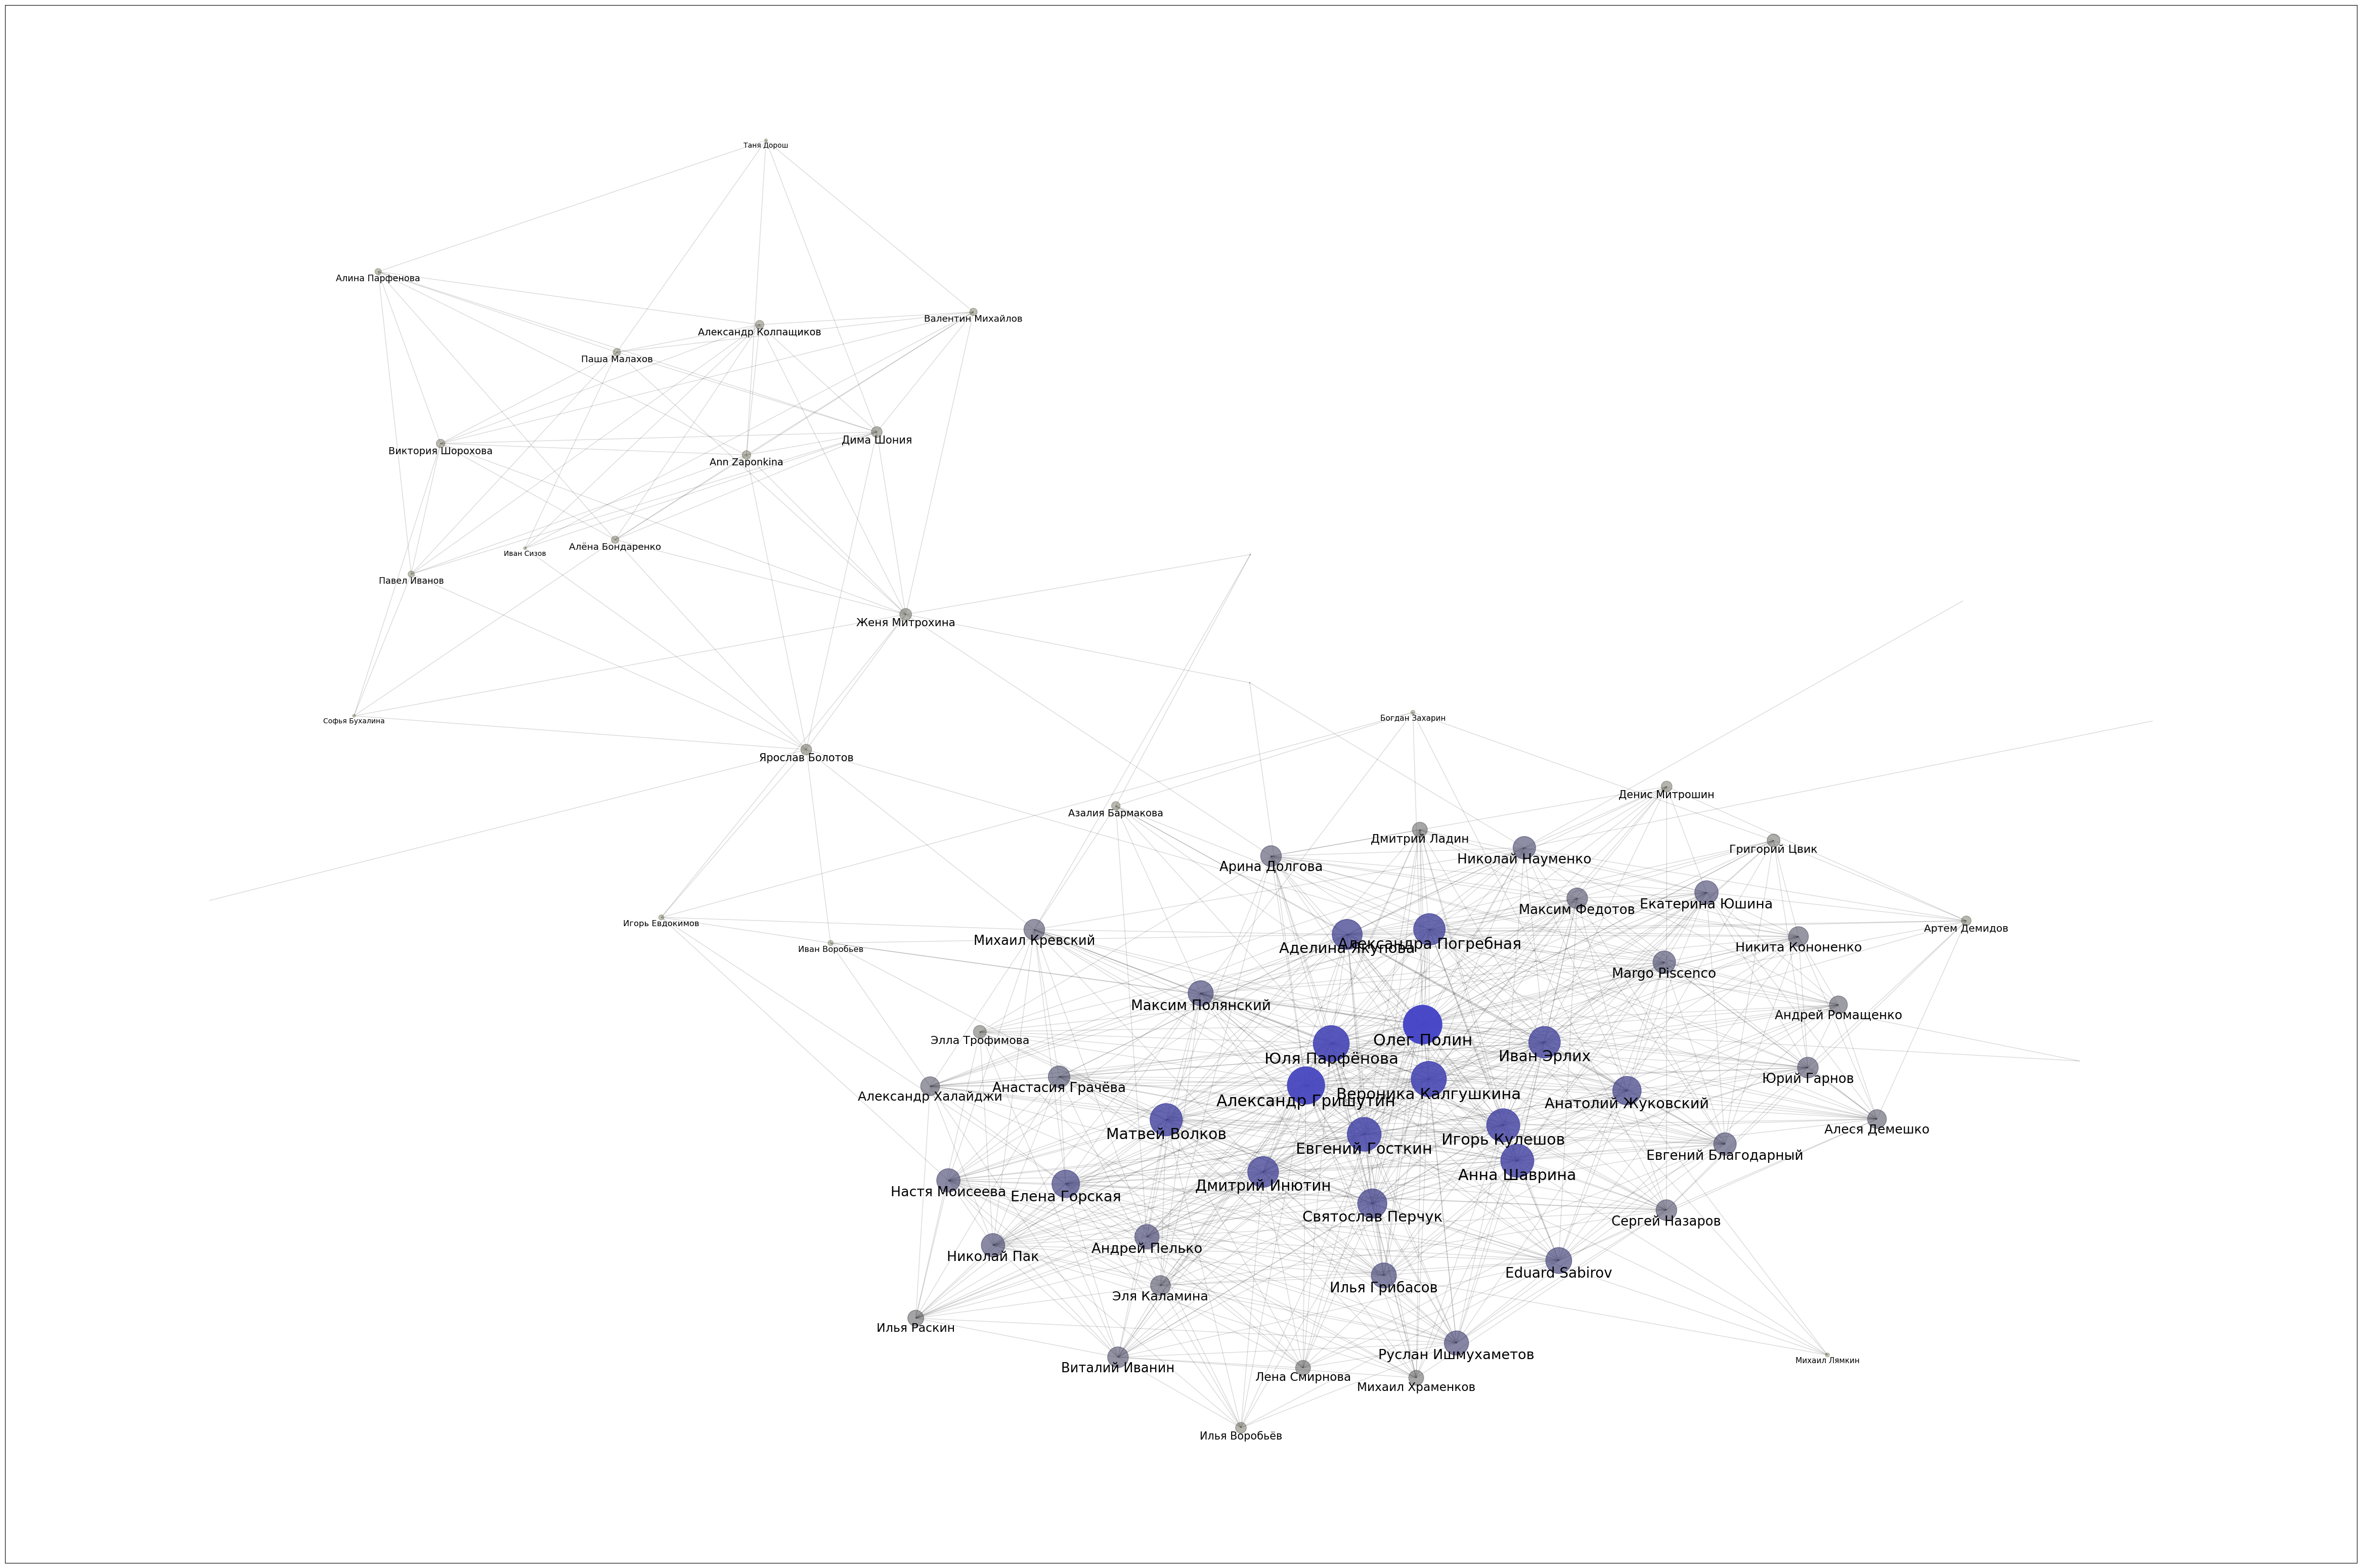

In [89]:
counter_global += 1
plt.figure(figsize=(60, 40))
layout = improve_layout(nx.kamada_kawai_layout(G))
list_params = labels_list_parameters(G, layout)
nx.draw_networkx_nodes(
    G, 
    pos=layout,
    node_size=[np.log(G.degree[d]) ** 6 for d in G.nodes()], # 1.5
    node_color=get_nodes_colors(G)
)
nx.draw_networkx_edges(G, pos=layout, alpha=0.15)
for params in list_params:
    nx.draw_networkx_labels(**params)

plt.savefig(f"my_colormap{counter_global}.png")
plt.show()

In [31]:
for s in nx.connected_components(G):
    print(s)

{27450116, 103159559, 137814280, 31637385, 108147592, 69090444, 93047312, 54109842, 282546451, 498201240, 99979546, 182581403, 54121629, 143835677, 224691741, 118381344, 134782625, 382553382, 61920679, 474257321, 142872618, 320786603, 239133355, 26050729, 195068593, 101922230, 321756344, 52912441, 53936570, 3656763, 223090364, 76025405, 75563326, 159682878, 387833921, 152861817, 19651650, 229886148, 92567621, 119205241, 140255562, 63362507, 114461030, 138968909, 100781646, 166218064, 177987155, 82561236, 381345876, 74233303, 69433176, 65732473, 119575260, 72957791, 7153638, 188462695, 209081062, 575974633, 183977194, 169698283, 111141867, 103502441, 62121191, 134955884, 104185969, 66009457, 809203, 136201585, 140433777, 96857977, 45141757, 9348223}
{40048161, 385862059}
{68032664, 711752874}
{150611301, 383118261}


In [32]:
G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

In [33]:
users_info = get_base_info(list(G.nodes()))

In [34]:
man_ids = []
woman_ids = []
cities_info = Counter()

for user in users_info:
  user_id = user['id']
  G.nodes[user_id]['sex'] = 'man' if user['sex'] == 2 else 'woman'
  if user['sex'] == 2:
    man_ids.append(user_id)
  else:
    woman_ids.append(user_id)
  try:
    G.nodes[user_id]['city'] = user['city']['title']
    cities_info[user['city']['title']] += 1
  except Exception as e:
    G.nodes[user_id]['city'] = ''
    # print(user['last_name'], e)
  try:
    G.nodes[user_id]['university'] = user['universities'][0]['name']
  except:
    G.nodes[user_id]['university'] = ''

In [35]:
print(f"Amount [man]:\t{len(man_ids)}\t({round(100 * len(man_ids) / len(G.nodes()), 1)}%)")
print(f"Amount [woman]:\t{len(woman_ids)}\t({round(100 * len(woman_ids) / len(G.nodes()), 1)}%)")

Amount [man]:	47	(65.3%)
Amount [woman]:	25	(34.7%)


In [36]:
print("Cities info:")
cities_list = sorted([[key, cities_info[key]] for key in cities_info.keys()], key=lambda x: -x[1])
for city, amount in cities_list:
  if amount > 3:
    print(f"{city}:\t{amount}")

Cities info:
Москва:	20
Санкт-Петербург:	5
Долгопрудный:	5
Барнаул:	4


In [37]:
print("Radius:\t", nx.radius(G))
print("Diameter:\t", nx.diameter(G))
print('Average shortest path length:\t', nx.average_shortest_path_length(G))
print('Average clustering coefficient:\t', nx.average_clustering(G))

Radius:	 3
Diameter:	 5
Average shortest path length:	 2.172926447574335
Average clustering coefficient:	 0.6266584435442771


In [38]:
clustering = nx.clustering(G)
# plt.bar(range(len(clustering)), clustering)

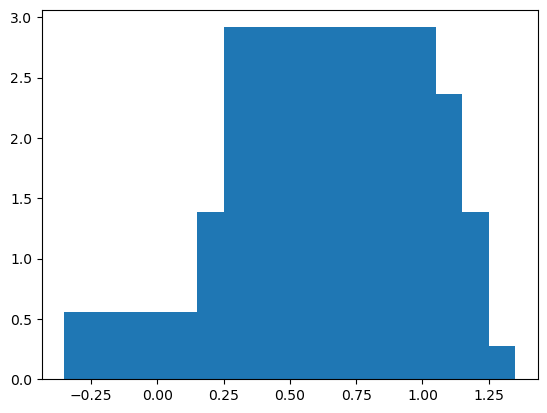

In [39]:
# print(clustering)
hist, bin_edges = np.histogram(list(clustering.values()), bins=10, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist)
plt.show()


In [40]:
pathes = Counter()
for n in nx.shortest_path_length(G):
  for i in n[1].values():
    pathes[i] += 1
for key in pathes.keys():
  pathes[key] //= 2    

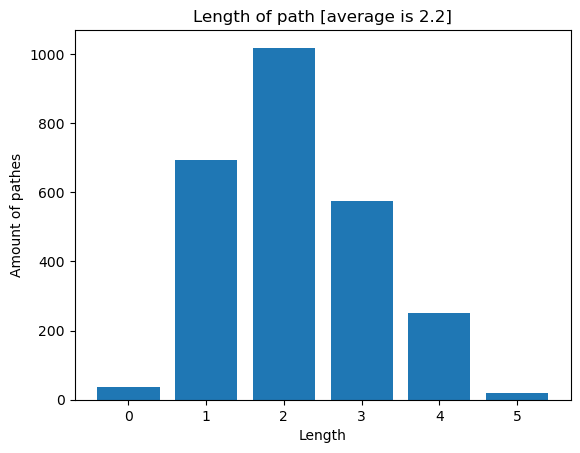

In [90]:
plt.bar(pathes.keys(), pathes.values())
plt.ylabel("Amount of pathes")
plt.title(f"Length of path [average is {round(nx.average_shortest_path_length(G), 1)}]")
plt.xlabel("Length")
plt.savefig(f"my_leght_hist{counter_global}.png")
plt.show()

In [42]:
degrees = Counter()
for _, degree in G.degree():
  degrees[degree] += 1

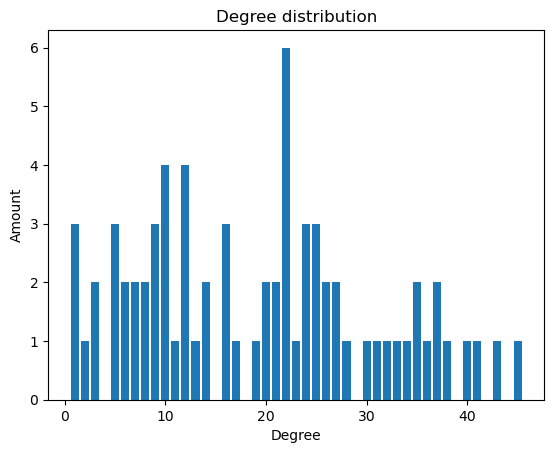

In [91]:
plt.bar(degrees.keys(), degrees.values())
plt.ylabel("Amount")
plt.title(f"Degree distribution")
plt.xlabel("Degree")
plt.savefig(f"my_degree_hist{counter_global}.png")
plt.show()

# Structural Analysis

In [44]:
def print_graph_parameters(graph, name="My graph"):
  print(f"Graph name: {name}")
  print("Diameter:\t", nx.diameter(graph))
  average_degree = sum(val for vertex, val in graph.degree()) / len(graph.nodes())
  print('Average degree:\t', round(average_degree, 2))
  print('Average clustering coefficient:\t', round(nx.average_clustering(graph), 2))

In [45]:
NODES = len(G.nodes())
EDGES = len(G.edges())

In [46]:
print_graph_parameters(G)

Graph name: My graph
Diameter:	 5
Average degree:	 19.22
Average clustering coefficient:	 0.63


In [47]:
print_graph_parameters(nx.erdos_renyi_graph(
    NODES, 
    EDGES / (NODES * (NODES - 1) / 2)), name="Erdos Renyi")

Graph name: Erdos Renyi
Diameter:	 3
Average degree:	 18.92
Average clustering coefficient:	 0.27


In [48]:
print_graph_parameters(
    nx.watts_strogatz_graph(
        NODES,
        round(sum(val for vertex, val in G.degree()) / NODES),
        0.5
        ), name="Watts-Strogatz")

Graph name: Watts-Strogatz
Diameter:	 3
Average degree:	 18.0
Average clustering coefficient:	 0.26


In [49]:
print_graph_parameters(
    nx.barabasi_albert_graph( 
        NODES,
        round(sum(val for vertex, val in G.degree()) / NODES) // 2,
        ), name="Barabasi-Albert")

Graph name: Barabasi-Albert
Diameter:	 3
Average degree:	 15.75
Average clustering coefficient:	 0.35


Из результатов, думаю, что наилучшая похожая модель - модель Erdos Renyi.

In [50]:
def centralities(G: nx.Graph):
    return {
        'degree': np.array([dc for dc in nx.degree_centrality(G).values()]),
        'closeness': np.array([dc for dc in nx.closeness_centrality(G).values()]),
        'betweenness': np.array([dc for dc in nx.betweenness_centrality(G).values()])
    }

Degree centrality


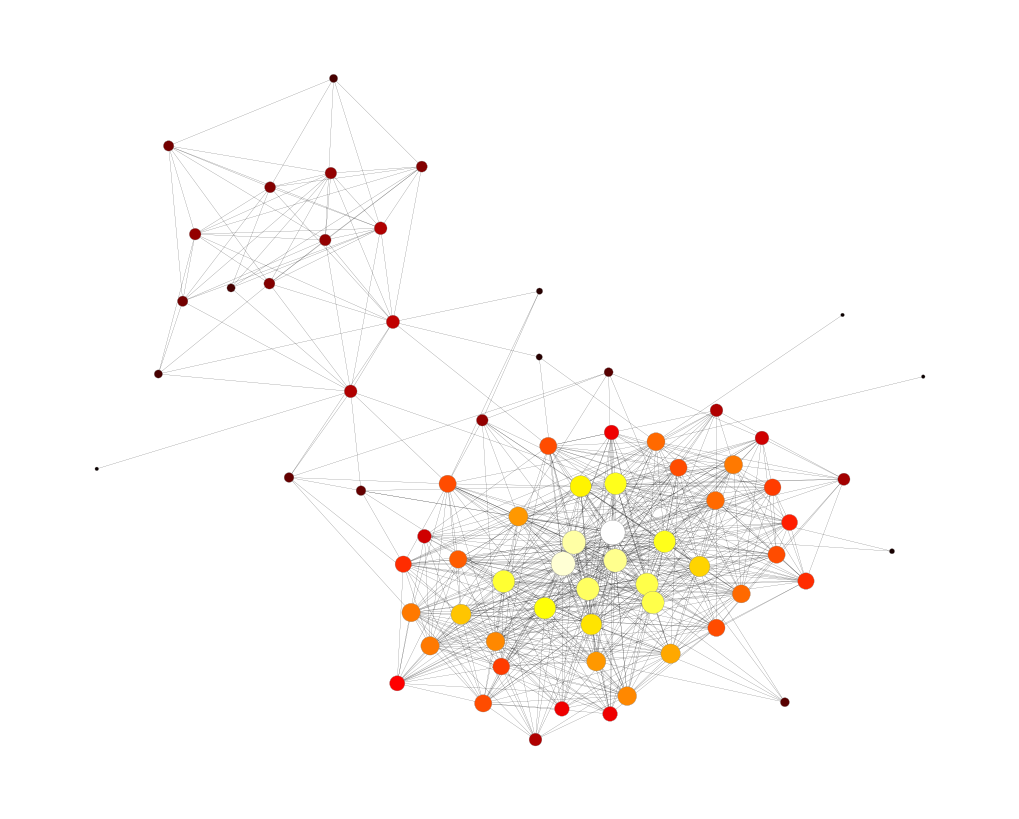

Closeness centrality


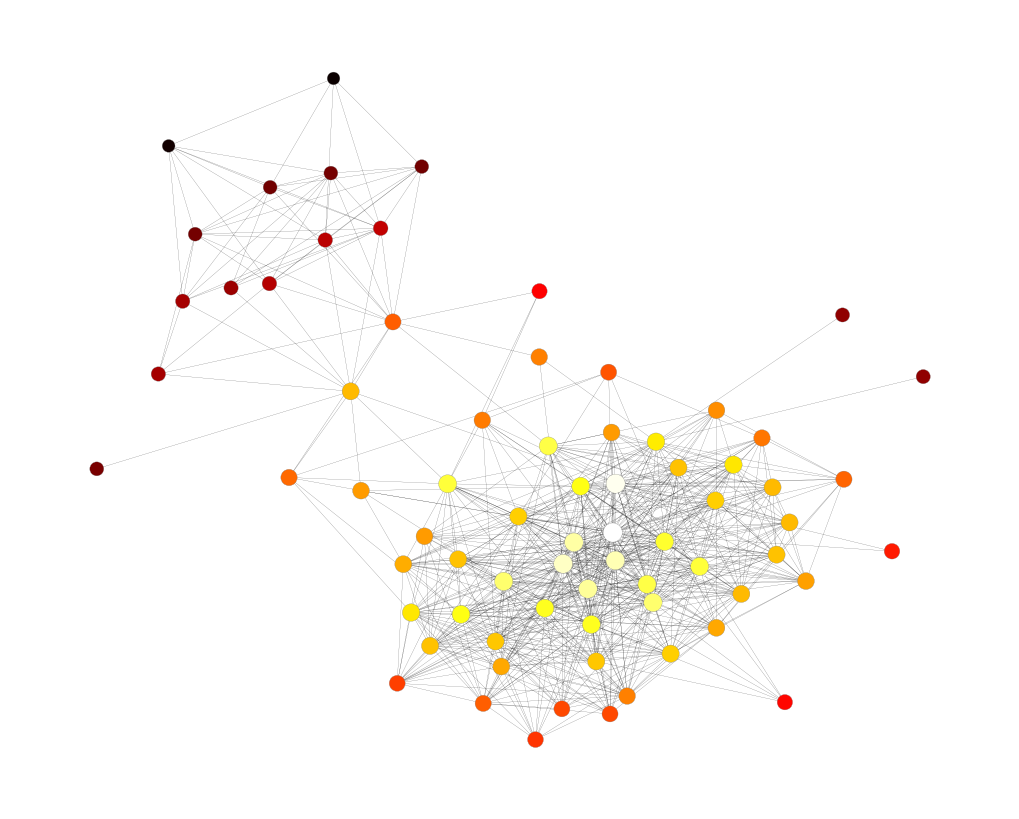

Betweenness centrality


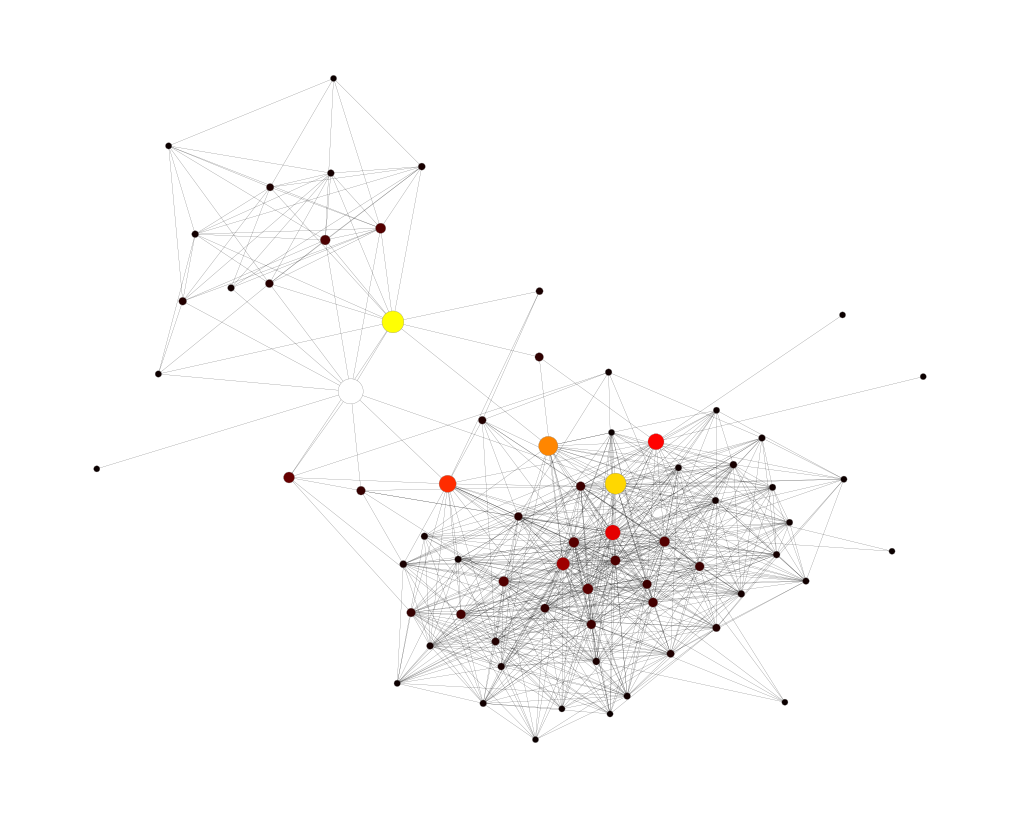

In [92]:
cases = [['degree', 500, 0, 'Degree centrality'], 
         ['closeness', 300, 0, 'Closeness centrality'], 
         ['betweenness', 1700, 20, 'Betweenness centrality']]
c = centralities(G)
for c_key, scale, bias, title in cases:
    print(title)
    plt.figure(figsize=(10, 8))
    # nx.draw_networkx_edges(G, pos=layout, alpha=0.25)
    nx.draw(G, 
            layout,
            width=0.1,
            linewidths=0.2,
            edgecolors='gray',

            cmap=plt.cm.hot,
            node_size=c[c_key] * scale + bias,
            node_color=c[c_key])
    plt.savefig(f"my_{c_key}{counter_global}.png")
    plt.show()
    # break

In [52]:
# get top-nodes
top_ids = sorted([[c_i, user_id] for c_i, user_id in zip(c['betweenness'], G.nodes())], key=lambda x: -x[0])

In [53]:
for _, user_id in top_ids[:2]:
  print(G.nodes[user_id]['first_name'], G.nodes[user_id]['last_name'])

Ярослав Болотов
Женя Митрохина


In [54]:
top_ids = sorted([[c_i, user_id] for c_i, user_id in zip(c['closeness'], G.nodes())], key=lambda x: -x[0])

In [55]:
for _, user_id in top_ids[:4]:
  print(G.nodes[user_id]['first_name'], G.nodes[user_id]['last_name'])

Олег Полин
Александра Погребная
Александр Гришутин
Вероника Калгушкина


In [56]:
PR = nx.pagerank(G)

In [57]:
PR = np.array(list(PR.values()))

In [58]:
# print(PR)

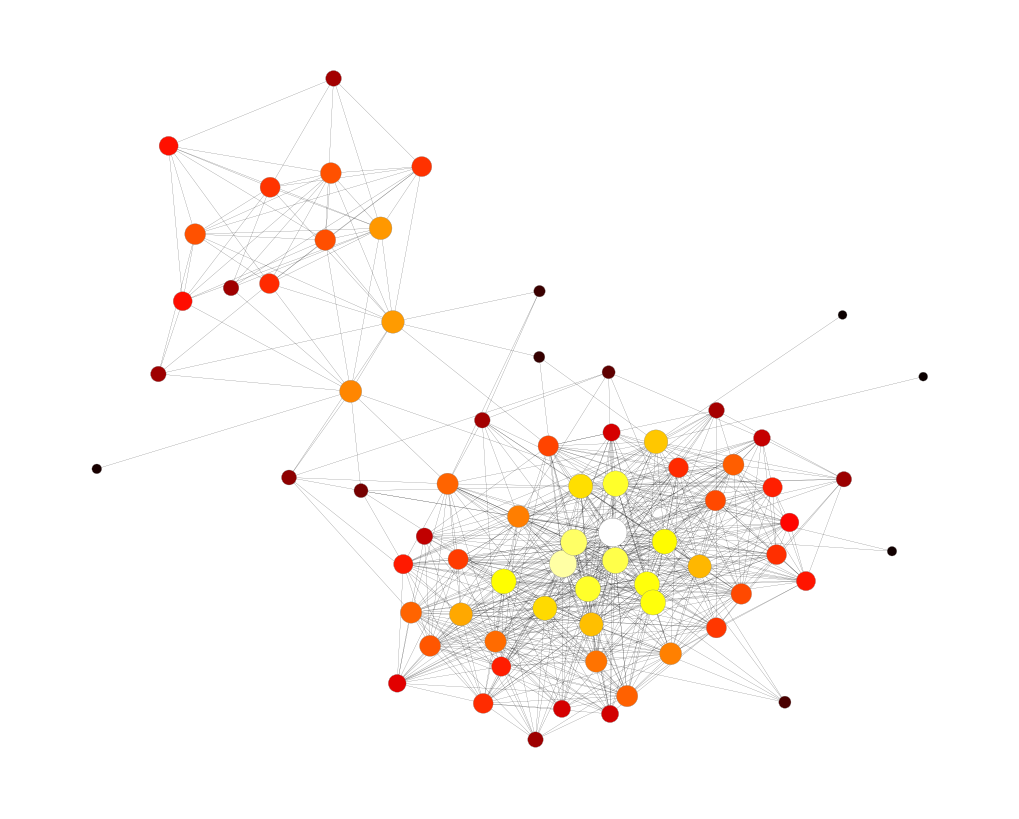

In [93]:
plt.figure(figsize=(10, 8))
nx.draw(G,
  layout,
  width=0.1,
  linewidths=0.2,
  edgecolors='gray',

  cmap=plt.cm.hot,
  node_size=PR * 15000,
  node_color=PR)
plt.savefig(f"my_pagerank{counter_global}.png")
plt.show()

In [60]:
for centrality_i in c:
  print(f"Page rank correlation with {centrality_i} centrality: {round(np.corrcoef(PR, c[centrality_i])[0, 1], 2)}")

Page rank correlation with degree centrality: 0.9
Page rank correlation with closeness centrality: 0.67
Page rank correlation with betweenness centrality: 0.38


In [61]:
top_ids = sorted([[c_i, user_id] for c_i, user_id in zip(PR, G.nodes())], key=lambda x: -x[0])

In [62]:
for _, user_id in top_ids[:4]:
  user = G.nodes[user_id]
  print(f"{user['first_name']} {user['last_name']} #\t{user['city']}, {user['university']}")

Олег Полин #	Долгопрудный, МФТИ (Физтех)
Александр Гришутин #	, МФТИ (Физтех)
Юля Парфёнова #	, 
Вероника Калгушкина #	Санкт-Петербург, СПбГУ


In [63]:
def get_mixing(G, attribute):
    mapping = {key: i for i, key in enumerate(set(nx.get_node_attributes(G, attribute).values()))}
    return nx.attribute_mixing_matrix(G, attribute, mapping=mapping), mapping

In [64]:
mixing, mapping = get_mixing(G, 'sex')

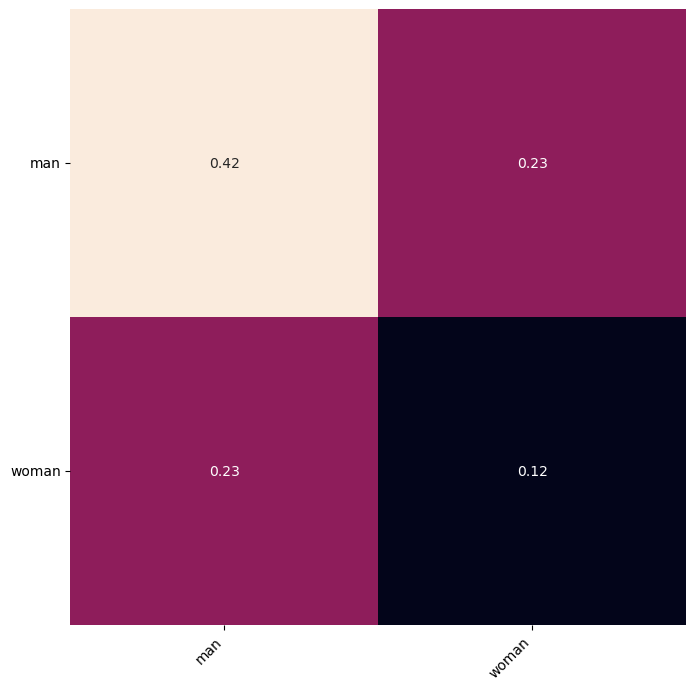

In [65]:
fig = plt.figure(figsize=(8, 8))

hmap = sns.heatmap(
    mixing,
    cbar=False,
    annot=True,
    square=True)
hmap.set_xticklabels(
    labels=[m for m in mapping], 
    rotation=45, 
    horizontalalignment='right')
hmap.set_yticklabels(
    labels=[m for m in mapping], 
    rotation=0)
plt.show()

In [66]:
mixing, mapping = get_mixing(G, 'city')

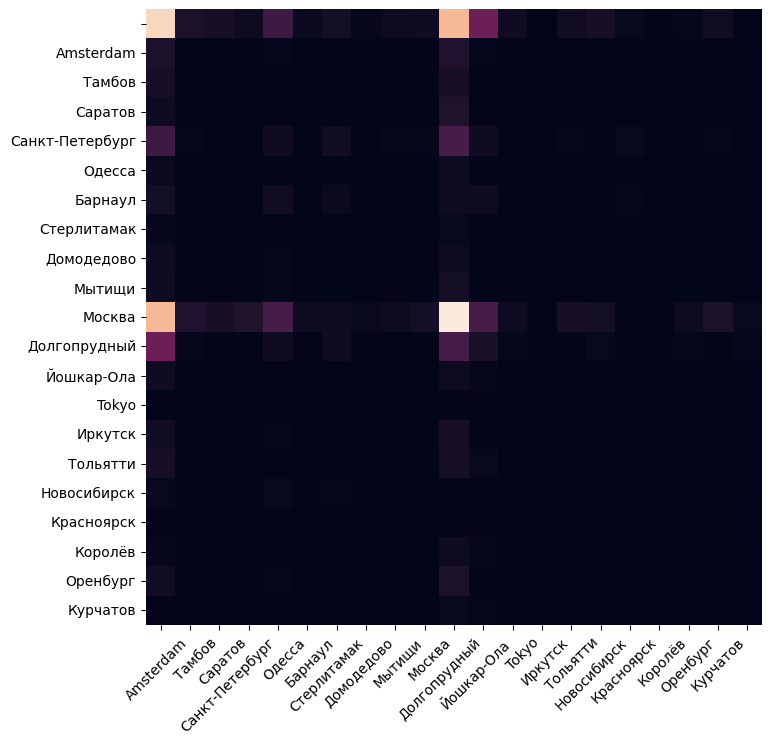

In [67]:
fig = plt.figure(figsize=(8, 8))

hmap = sns.heatmap(
    mixing,
    cbar=False,
    annot=False,
    square=True)
hmap.set_xticklabels(
    labels=[m for m in mapping], 
    rotation=45, 
    horizontalalignment='right')
hmap.set_yticklabels(
    labels=[m for m in mapping], 
    rotation=0)
plt.show()

In [68]:
mixing, mapping = get_mixing(G, 'university')

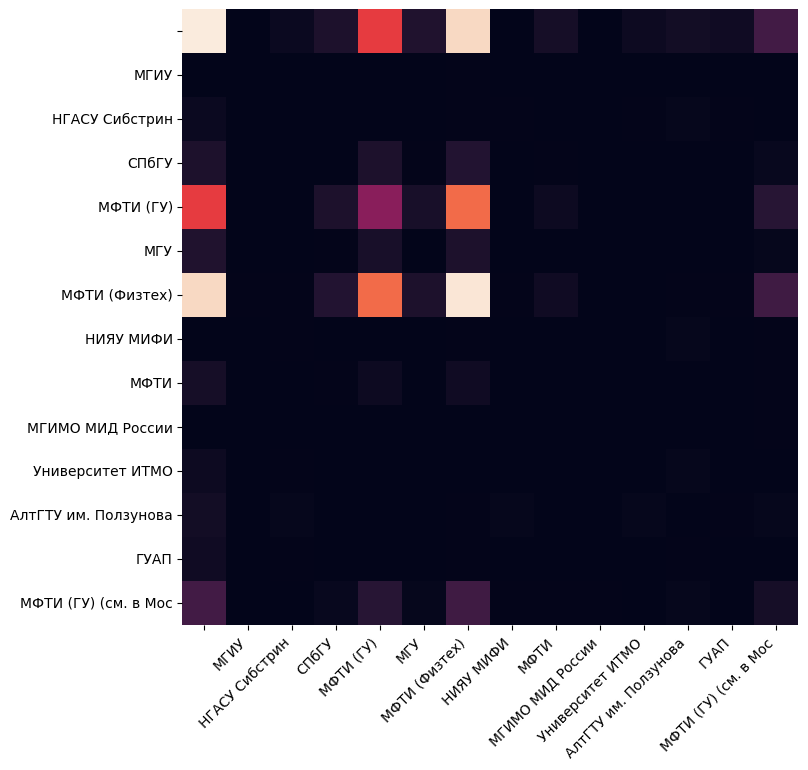

In [69]:
fig = plt.figure(figsize=(8, 8))

BORDER_SIZE_NAME = 20

hmap = sns.heatmap(
    mixing,
    cbar=False,
    # linewidths=0.01,
    annot=False,
    square=True)
hmap.set_xticklabels(
    labels=[m[:BORDER_SIZE_NAME] for m in mapping], 
    rotation=45, 
    horizontalalignment='right')
hmap.set_yticklabels(
    labels=[m[:BORDER_SIZE_NAME] for m in mapping], 
    rotation=0)
plt.show()

In [70]:
def get_name(node_dict):
  return node_dict['last_name']

In [71]:
def sim_matrices(G):
    A = nx.to_numpy_array(G)
    # Друзей много, поэтому как-то ограничим рассматриваемое количество \
    # для большей наглядности
    indexes = np.where(A.sum(axis=0) > 31)[0]
    A = A[indexes][:, indexes]
    corr = np.corrcoef(A)
    J = np.zeros(A.shape)
    for i, j, c in nx.jaccard_coefficient(nx.from_numpy_array(A)):
        J[i, j] = c
        J[j, i] = c
    cos = cosine_similarity(A)
    return A, corr, J, cos, indexes

In [72]:
A, corr, J, cos, indexes = sim_matrices(G)

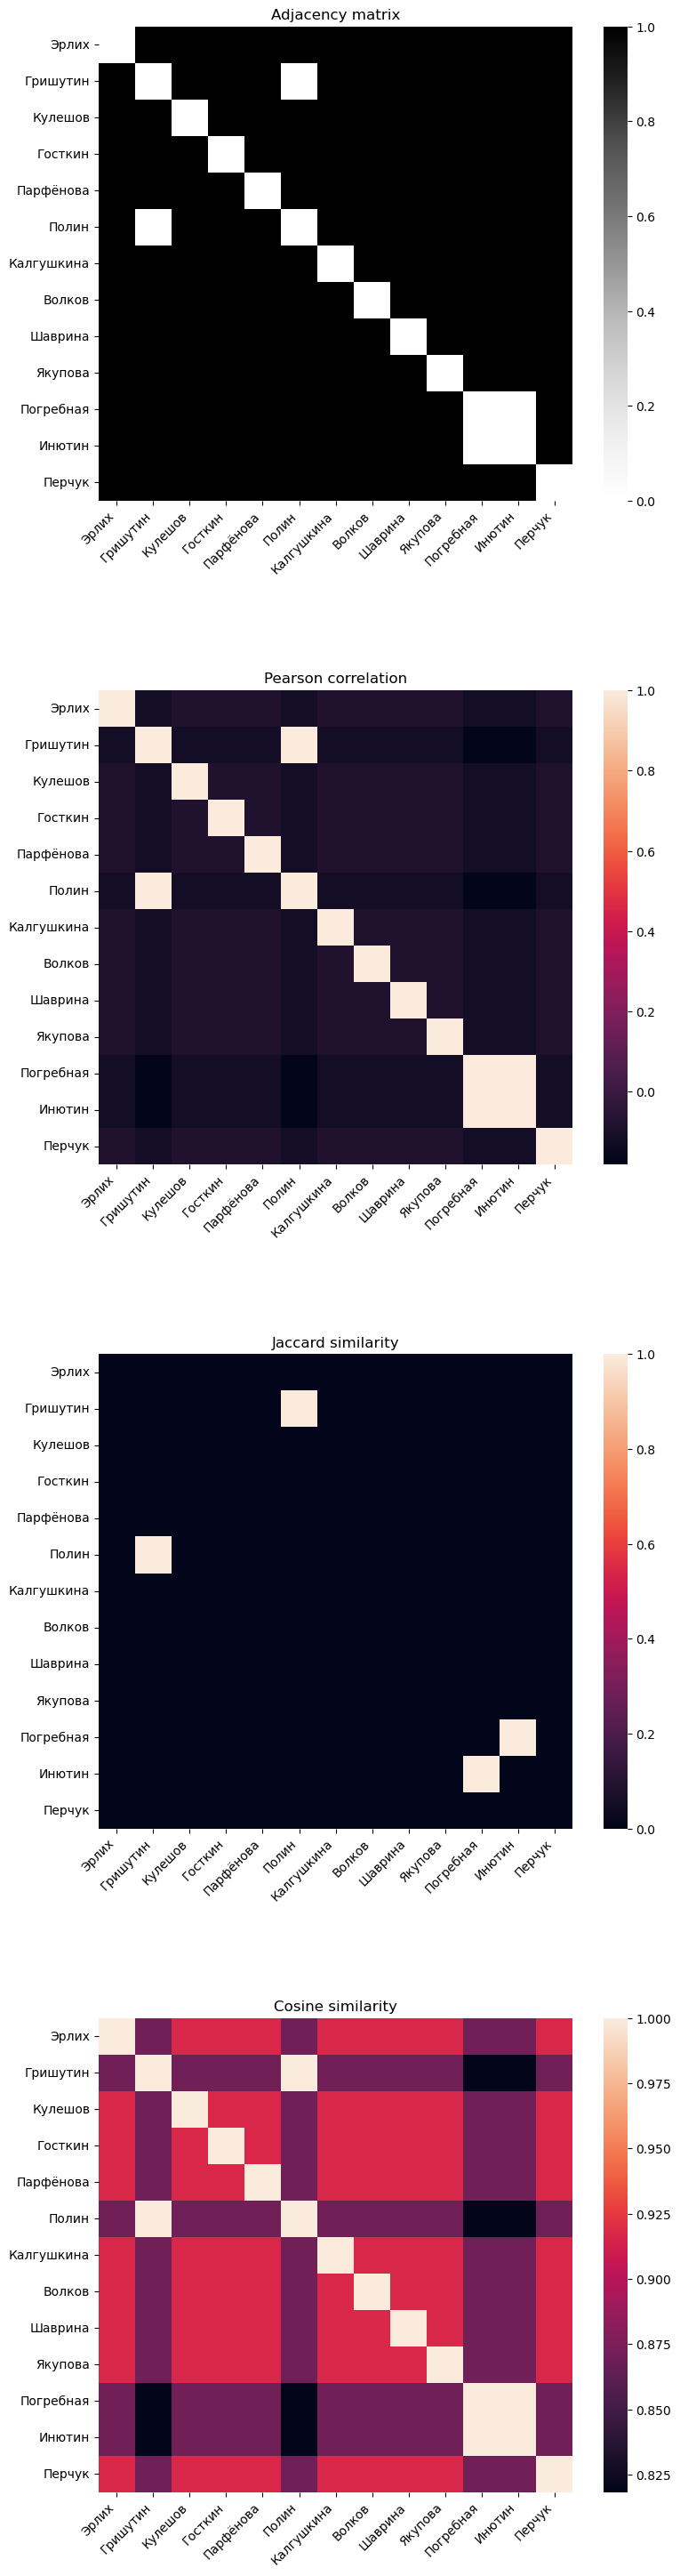

In [73]:
fig = plt.figure(figsize=(9, 9*4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [[1, A, plt.cm.Greys, 'Adjacency matrix'], 
         [2, corr, None, 'Pearson correlation'], 
         [3, J, None, 'Jaccard similarity'], 
         [4, cos, None, 'Cosine similarity'], ]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(
        matrix,
        cmap=cmap,
        square=True,
        yticklabels=[get_name(G.nodes[n]) for i, n in enumerate(G.nodes) if i in indexes])
    hmap.set_xticklabels(
        labels=[get_name(G.nodes[n]) for i, n in enumerate(G.nodes) if i in indexes], 
        rotation=45, 
        horizontalalignment='right')
    plt.title(t)

# Community Detection

In [74]:
def k_core_decompose(graph):
    return np.array(list(nx.core_number(graph).values()))

In [75]:
labels = k_core_decompose(G)

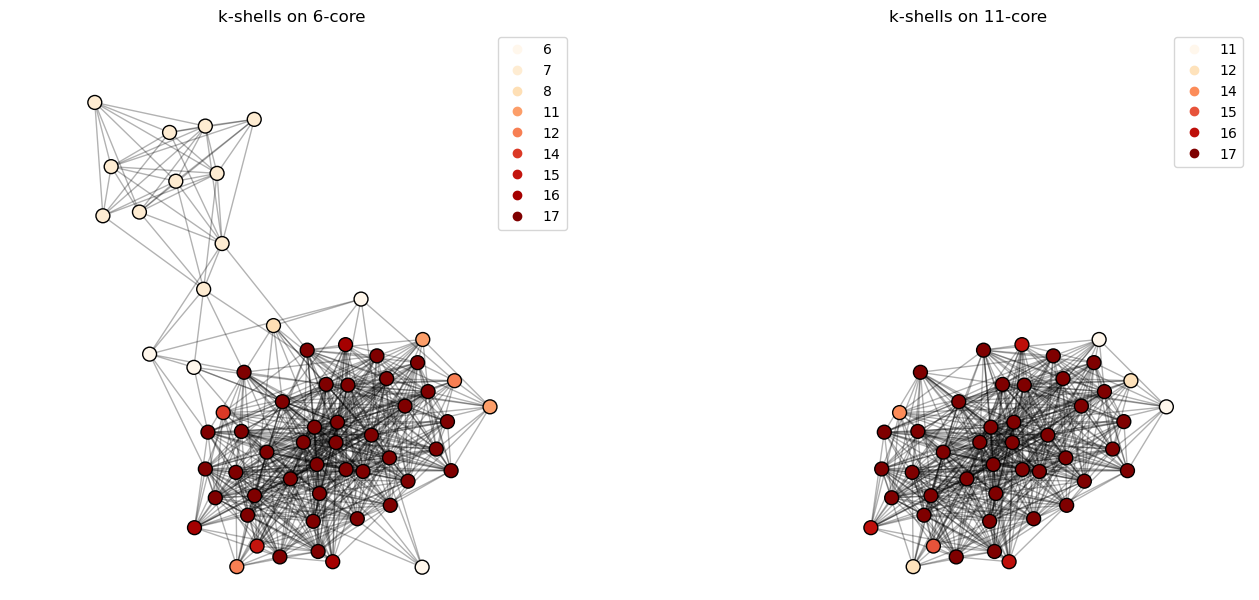

In [76]:
pos = layout
plt.figure(figsize=(8*2, 8*2))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

for i in range(5, 15, 5):
    plt.subplot(2, 2, i//5)
    subG = nx.k_core(G, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        pos,
        cmap=plt.cm.OrRd,
        node_color=k_core_decompose(subG), 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        subG, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black'
    )
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

In [77]:
def edge_betweenness(G, n):
    com_gen = nx.algorithms.community.girvan_newman(G)
    labels = []
    for i in range(n):
        communities = next(com_gen)
        c_com = []
        for node in G.nodes:
            for i, c in enumerate(communities):
                if node in c:
                    c_com.append(i)
        labels.append(c_com)
    return np.array(labels)

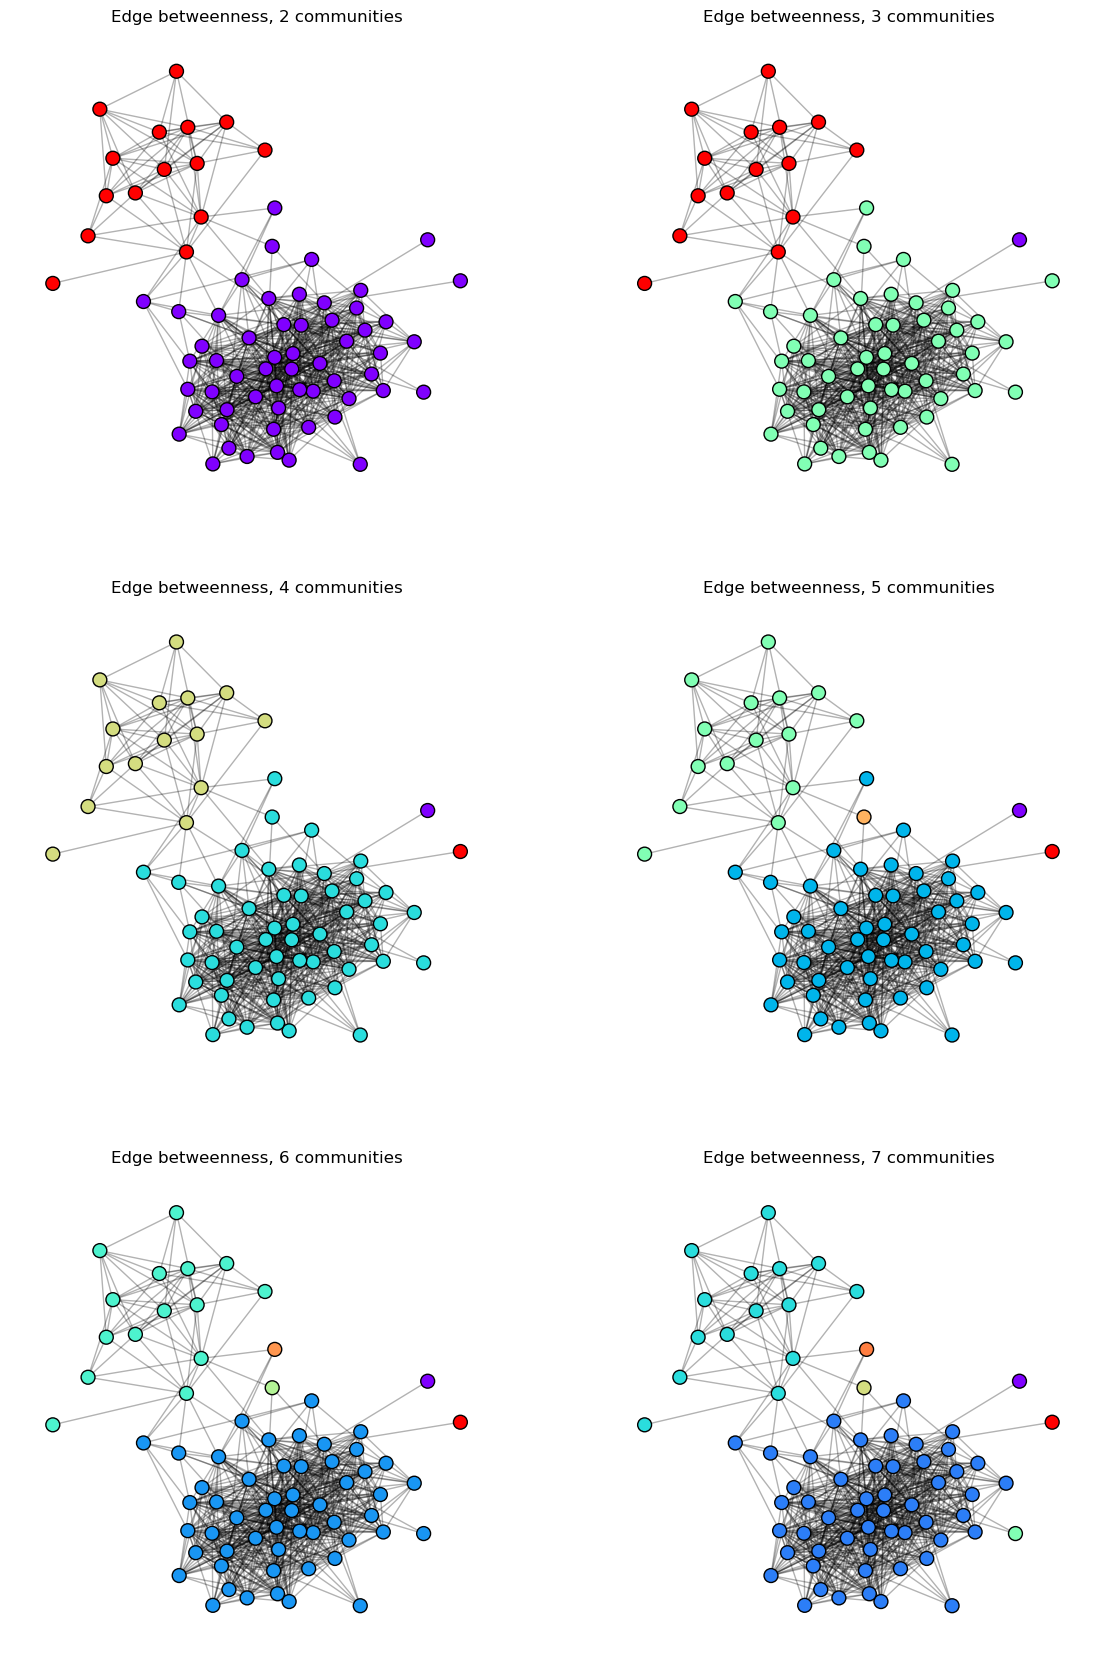

In [78]:
plt.figure(figsize=(7*2, 7*3))
colors = edge_betweenness(G, 6)
for i in range(colors.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

In [79]:
def norm_laplacian(A):
    return nx.normalized_laplacian_matrix(nx.from_numpy_matrix(np.array(A))).toarray()


def spectral_embedding(L, n_components):
    vals, vecs = np.linalg.eigh(L, )
    return vecs[:, 1:n_components + 1]

In [80]:
def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L = norm_laplacian(A)
    embedding = spectral_embedding(L, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

In [81]:
labels = spectral_clustering(G, 4, 3)

<class 'networkx.utils.decorators.argmap'> compilation 57:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


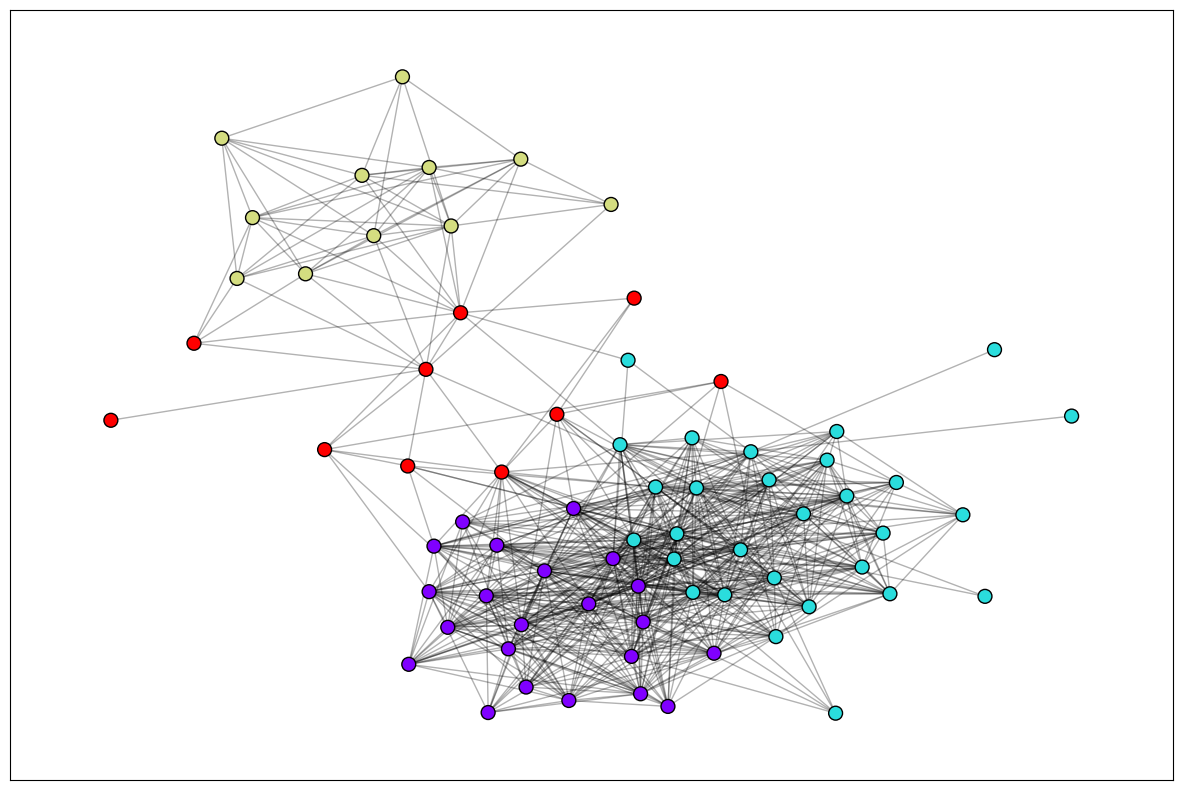

In [82]:
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    edgecolors='black'
)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show()

<class 'networkx.utils.decorators.argmap'> compilation 57:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


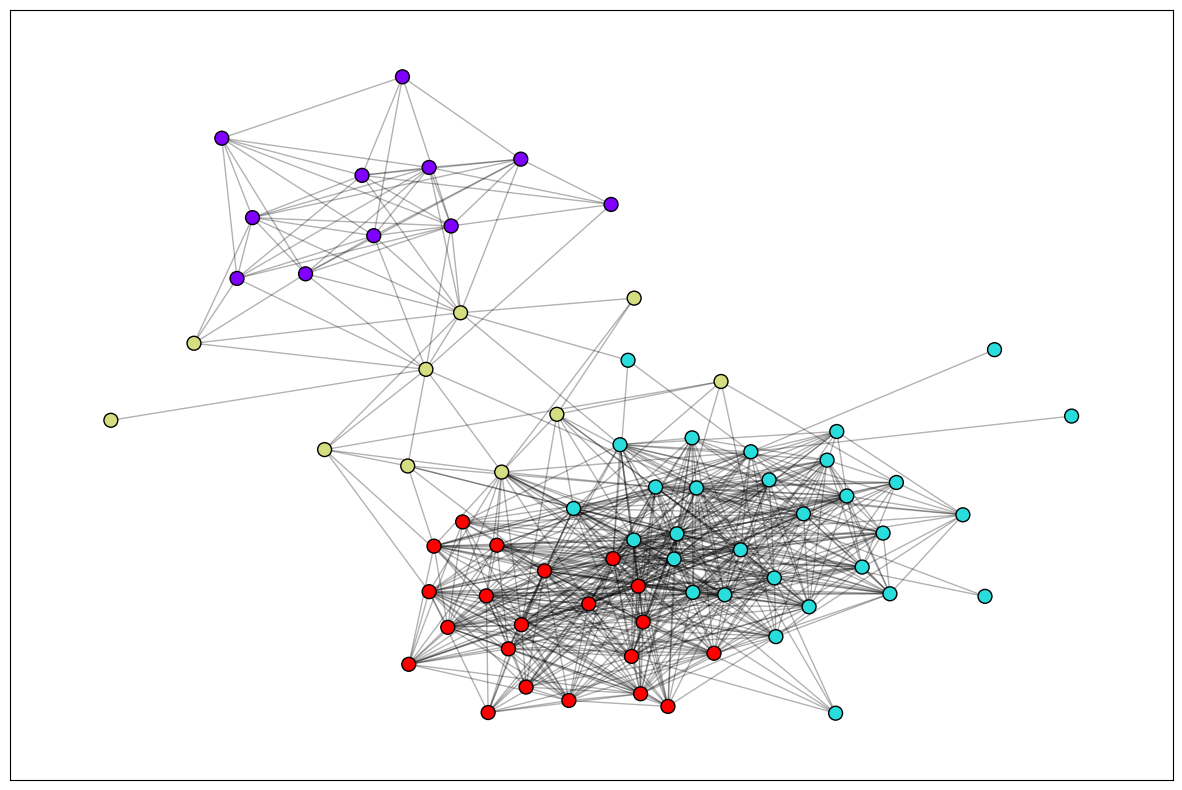

In [94]:
labels = spectral_clustering(G, 4, 5)
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    edgecolors='black'
)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.savefig(f"my_communities{counter_global}.png")
plt.show()

In [84]:
def edge_betw_modularity(G, n):
    com_gen = nx.algorithms.community.girvan_newman(G)
    return np.array([nx.algorithms.community.modularity(
        G, communities=next(com_gen)) for _ in range(n)])

In [85]:
n_iterations = 20
modularity = edge_betw_modularity(G, n_iterations)

C:\Users\WordedWord75049\AppData\Local\Temp\ipykernel_15080\3073627382.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(


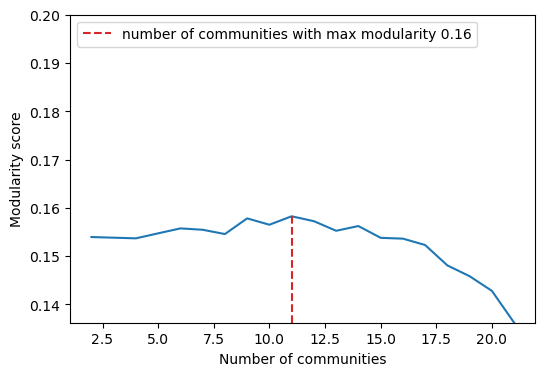

In [86]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, modularity)
best_n = np.argmax(modularity) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity))
plt.plot(
    [best_n, best_n], [min(modularity), max(modularity)], 
    'k--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.ylim((modularity.min(), 0.2))
plt.show()